In [1]:
#immport
import torch
import torch.nn.functional as F

torch.manual_seed(1)


##1. 파이토치로 소프트맥스의 비용 함수 구현하기 (로우-레벨)


In [2]:
z = torch.FloatTensor([1, 2, 3])

In [3]:
#z를 소프트맥스 함수의 입력으로 사용, 결과 확인
#dim: A dimension along which Softmax will be computed (so every slice along dim will sum to 1).
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


3개의 원소의 값이 0과 1사이의 값을 가지는 벡터로 변환된 것을 볼 수 있습니다. 이 원소들의 값의 합이 1인지 확인해보겠습니다.

In [4]:
hypothesis.sum()

tensor(1.)

### 비용 함수를 직접 구현해보겠습니다. 우선 임의의 3 × 5 행렬의 크기를 가진 텐서를 만듭니다.

In [5]:
z = torch.rand(3, 5, requires_grad=True)
print(z)

tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
        [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
        [0.6387, 0.5247, 0.6826, 0.3051, 0.4635]], requires_grad=True)


이제 이 텐서에 대해서 소프트맥스 함수를 적용합니다. 단, 각 샘플에 대해서 소프트맥스 함수를 적용하여야 하므로 두번째 차원에 대해서 소프트맥스 함수를 적용한다는 의미에서 dim=1을 써줍니다.

In [6]:
hypothesis = F.softmax(z, dim=1)
print(hypothesis)
print(hypothesis.sum(dim = 1))  # 열을 제거. 각 행별로 합을 더함
#print(hypothesis.sum(dim = 0))

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


이제 각 행의 원소들의 합은 1이 되는 텐서로 변환되었습니다. **소프트맥스 함수의 출력값은 결국 예측값**입니다. **즉, 위 텐서는 3개의 샘플에 대해서 5개의 클래스 중 어떤 클래스가 정답인지를 예측한 결과**입니다.

이제 각 샘플에 대해서 임의의 레이블을 만듭니다.

In [7]:
y = torch.randint(5, (3,)).long()
'''Returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive).

The shape of the tensor is defined by the variable argument size.
parameters:
- low (int, optional) – Lowest integer to be drawn from the distribution. Default: 0.

- high (int) – One above the highest integer to be drawn from the distribution.

- size (tuple) – a tuple defining the shape of the output tensor.

'''
print(y)

tensor([0, 2, 1])


이제 각 레이블에 대해서 원-핫 인코딩을 수행합니다.

In [10]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis) 
y_one_hot.scatter_(1, y.unsqueeze(1), 1)
print(y_one_hot)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


위의 연산에서 어떻게 원-핫 인코딩이 수행되었는지 보겠습니다. 우선, torch.zeros_like(hypothesis)를 통해 모든 원소가 0의 값을 가진 3 × 5 텐서를 만듭니다. 그리고 이 텐서는 y_one_hot에 저장이 된 상태입니다.

두번째 줄을 해석해봅시다. y.unsqueeze(1)를 하면 (3,)의 크기를 가졌던 y 텐서는 (3 × 1) 텐서가 됩니다. 즉, 다시 말해서 y.unsqueeze(1)의 결과는 아래와 같습니다.

In [9]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


그리고 scatter의 첫번째 인자로 dim=1에 대해서 수행하라고 알려주고, 세번째 인자에 숫자 1을 넣어주므로서 두번째 인자인 y_unsqeeze(1)이 알려주는 위치에 숫자 1을 넣도록 합니다. 앞서 텐서 조작하기 2챕터에서 연산 뒤에 _를 붙이면 In-place Operation (덮어쓰기 연산)임을 배운 바 있습니다. 이에 따라서 y_one_hot의 최종 결과는 결국 아래와 같습니다.

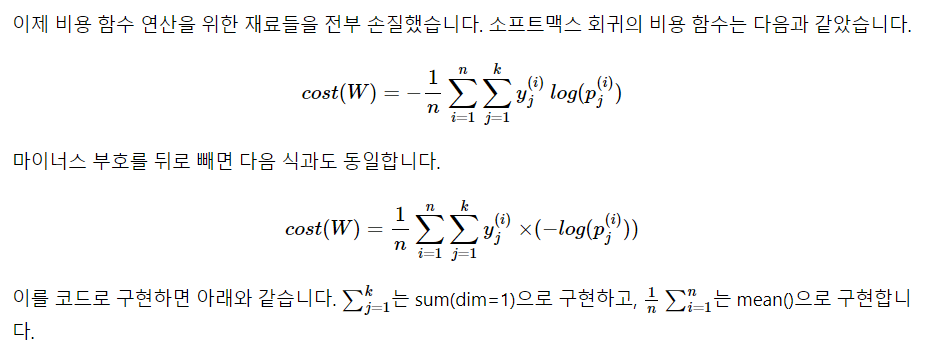



In [11]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


## 2. 파이토치로 소프트맥스의 비용 함수 구현하기 (하이-레벨)

1. F.softmax() + torch.log() = F.log_softmax()
앞서 소프트맥스 함수의 결과에 로그를 씌울 때는 다음과 같이 소프트맥스 함수의 출력값을 로그 함수의 입력으로 사용했습니다.

In [12]:
# Low level
torch.log(F.softmax(z, dim=1)) #F.softmax = hypothesis

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

그런데 파이토치에서는 두 개의 함수를 결합한 F.log_softmax()라는 도구를 제공합니다.

In [13]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

2. F.log_softmax() + F.nll_loss() = F.cross_entropy()

앞서 로우-레벨로 구현한 비용 함수는 다음과 같았습니다.

In [14]:
# Low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

그런데 위의 수식에서 torch.log(F.softmax(z, dim=1))를 방금 배운 F.log_softmax()로 대체할 수 있습니다.

In [15]:
# 두번째 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

이를 더 간단하게 하면 다음과 같습니다. F.nll_loss()를 사용할 때는 원-핫 벡터를 넣을 필요없이 바로 실제값을 인자로 사용합니다.

In [16]:
# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

여기서 nll이란 Negative Log Likelihood의 약자입니다. 위에서 nll_loss는 F.log_softmax()를 수행한 후에 남은 수식들을 수행합니다. 이를 더 간단하게 하면 다음과 같이 사용할 수 있습니다.

**F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있습니다.**

**F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않습니다.**

In [17]:
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward0>)